<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis_1_1_stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# This model os a binary classification model which classifies cells as infected or not infected.
# Dataset to be used https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
##### 27,558 cell images - from thin blood smear slides - contains both infected and uninfected cells.

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, RandomFlip, RandomRotation, Resizing, Rescaling, RandomZoom
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC, Precision, Recall
from google.colab import drive

In [26]:
dataset,dataset_info = tfds.load('malaria',as_supervised=True,with_info=True, shuffle_files = True,split=['train'])

In [27]:
# Spliting our dataset into trianing, validation and testing

def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    train_dataset = dataset.take(int(train_ratio * dataset_size))  # Training set
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))  # Remaining
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))  # Validation set
    test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))  # Test set

    return train_dataset, val_dataset, test_dataset


In [28]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset,val_dataset,test_dataset = split_dataset(dataset[0],train_ratio,val_ratio,test_ratio)
# print(list(train_dataset.take(1).as_numpy_iterator())), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())


In [29]:
image_size = 224

# Resizing and rescaling using layers
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.Rescaling(1. / 255)
])

augment_layers = tf.keras.Sequential([
    RandomFlip(mode="horizontal_and_vertical"),
    RandomRotation(0.1, fill_mode='reflect'),
    RandomZoom(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05), fill_mode='reflect'),
    tf.keras.layers.RandomContrast(factor=0.1),
])

def add_noise_contrast(image):
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Slight contrast changes
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=image.dtype)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)  # Add Gaussian noise
    return image

In [30]:
# Augmentation combining both tf.image and layers

def augmented_combined(image, label):
    image = resize_rescale_layers(image)
    image = augment_layers(image, training=True)
    image = add_noise_contrast(image)
    return image, label

In [31]:
batch_size = 32
buffer_size = 1000

# For the training dataset
train_dataset = (
    train_dataset
    .shuffle(buffer_size, reshuffle_each_iteration=True)
    .map(augmented_combined)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# For the validation dataset - only resize and rescale
val_dataset = (
    val_dataset
    .shuffle(buffer_size, reshuffle_each_iteration=True)
    .map(lambda image, label: (resize_rescale_layers(image), label))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# For the test dataset - only resize and rescale
test_dataset = (
    test_dataset
    .map(lambda image, label: (resize_rescale_layers(image), label))
    .batch(batch_size)
)

In [32]:
# Confirm correct shuffling

train_dataset
val_dataset
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

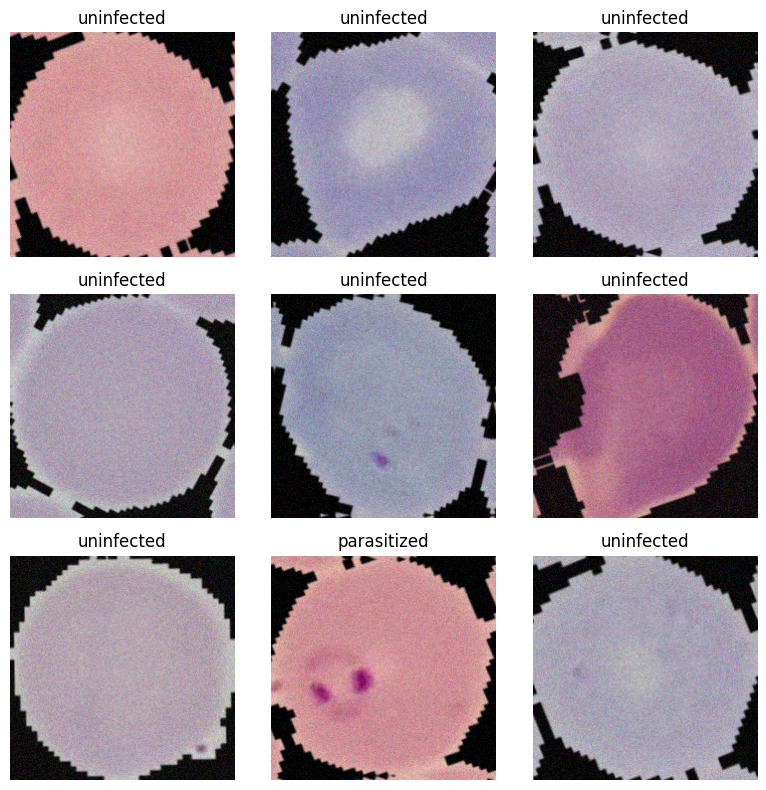

In [33]:
# Plotting images from the dataset

plt.figure(figsize=(8, 8))
for i, (images, labels) in enumerate(train_dataset.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy())
    plt.title(dataset_info.features['label'].int2str(labels.numpy()))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
# Building our model

channel_size = 3
dropout_rate = 0.5
regularization_rate = 0.01

model = Sequential([
    InputLayer(shape=(image_size, image_size, channel_size)),

    # First Convolutional Block
    Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(regularization_rate)),
    MaxPooling2D(pool_size=2, strides=2),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    MaxPooling2D(pool_size=2, strides=2),

    # Third Convolutional Block (Optional)
    Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    MaxPooling2D(pool_size=2, strides=2),

    # Dense Layer
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,185 (84.92 MB)

 Trainable params: 22,261,185 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
metrics = [
    BinaryAccuracy(name='accuracy'),
    TruePositives(name='tp'),
    TrueNegatives(name='tn'),
    FalsePositives(name='fp'),
    FalseNegatives(name='fn'),
    AUC(name='auc'),
    Precision(name='precision'),
    Recall(name='recall')
    ]

In [36]:
# Defining our optimizer, loss function, measurement metrics and compiling our model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= metrics,
)

In [37]:
# epoch and batch log
csv_callback = CSVLogger('log.csv', separator=',', append=True)

In [38]:
# Having a smooth linear warmup rate at the starts improve our models stability and leads to a better outcome.
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta = 0,
    restore_best_weights=True,
    mode = 'auto',
    verbose=1
)

# Speed and stability
# learning_rate_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [39]:
# Training our model

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[callbacks, csv_callback ],
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6004 - auc: 0.6428 - fn: 1526.3585 - fp: 2403.6677 - loss: 1.0057 - precision: 0.5902 - recall: 0.6895 - tn: 3103.0916 - tp: 4006.8796
Epoch 1: val_loss improved from inf to 0.34953, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 322s 459ms/step - accuracy: 0.6006 - auc: 0.6430 - fn: 1527.1957 - fp: 2405.8101 - loss: 1.0053 - precision: 0.5904 - recall: 0.6896 - tn: 3108.9392 - tp: 4014.0029 - val_accuracy: 0.8980 - val_auc: 0.9503 - val_fn: 26.0000 - val_fp: 255.0000 - val_loss: 0.3495 - val_precision: 0.8424 - val_recall: 0.9813 - val_tn: 1111.0000 - val_tp: 1363.0000 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9234 - auc: 0.9567 - fn: 320.7982 - fp: 527.0624 - loss: 0.2954 - precision: 0.9046 - recall: 0.9477 - tn: 4984.2891 - tp: 5207.8477
Epoch 2: val_loss improved from 0.34953 to 0.22668, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 3

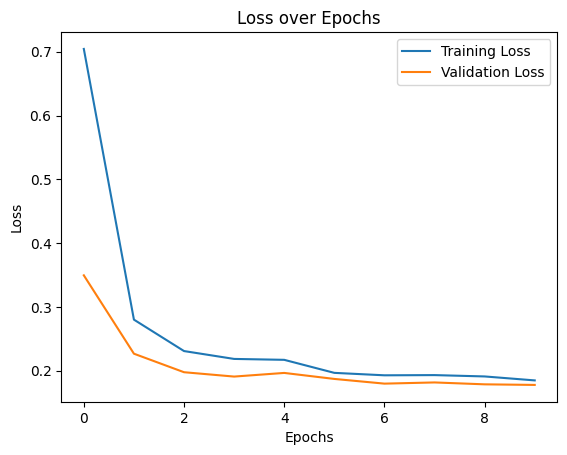

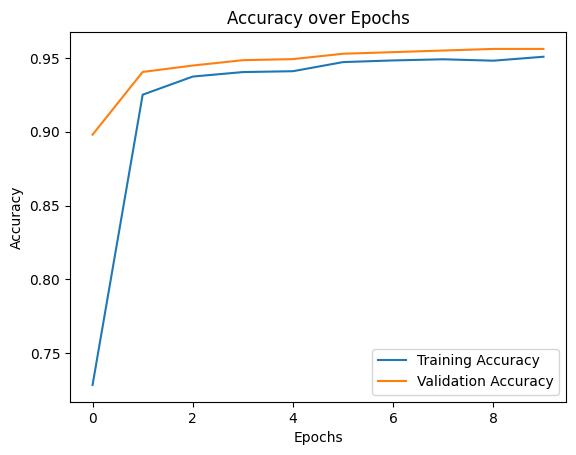

In [40]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [41]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9502 - auc: 0.9787 - fn: 34.0114 - fp: 38.1023 - loss: 0.1820 - precision: 0.9468 - recall: 0.9535 - tn: 676.2273 - tp: 674.6818


[0.18156515061855316,
 0.9474065899848938,
 1291.0,
 1321.0,
 76.0,
 69.0,
 0.9804357290267944,
 0.9444038271903992,
 0.9492647051811218]

In [43]:
labels = []
inp = []

# Collect data from the dataset
for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

inp_array = np.concatenate(inp, axis=0)
labels_array = np.concatenate(labels, axis=0)

print(f"Input shape: {inp_array.shape}")
print(f"Labels shape: {labels_array.shape}")

Input shape: (2757, 224, 224, 3)
Labels shape: (2757,)


In [44]:
predicted = model.predict(inp_array).flatten()

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


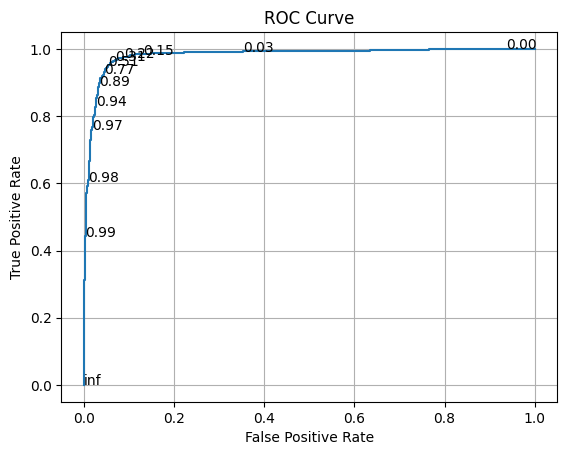

In [45]:
fp, tp, thresholds = roc_curve(labels_array, predicted)

# Plot ROC curve
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()

# Annotate thresholds
skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], f"{thresholds[i]:.2f}")

plt.show()

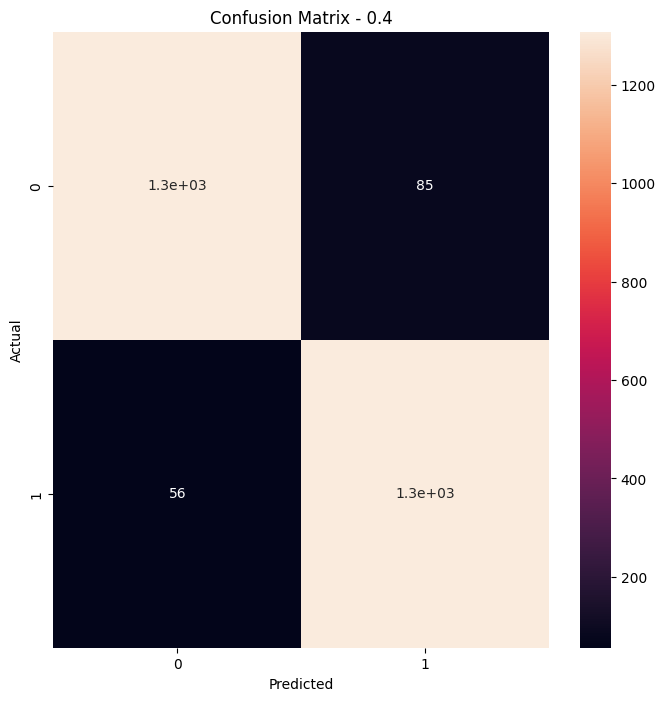

In [49]:
# Confusion Matrix

threshold = 0.4

con_metrics = confusion_matrix(labels_array, predicted > threshold)
plt.figure(figsize=(8,8))

sns.heatmap(con_metrics, annot=True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
def labeler(x):
  if(x<0.5):
    return str('Postivie')
  else:
    return str('Negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


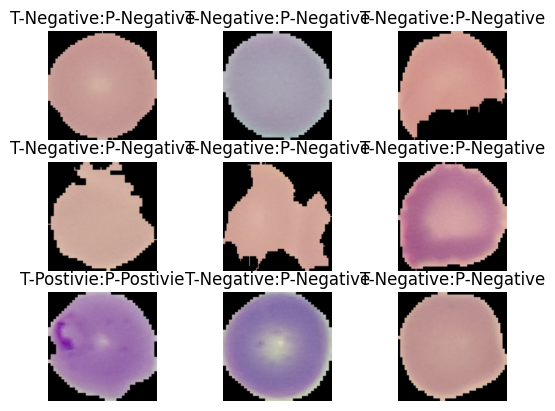

In [51]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str("T-"+labeler(label.numpy()[0])) + ":" + str("P-"+labeler(model.predict(image)[0][0])))

  plt.axis('off')

In [52]:
# Saving our model

drive.mount('/content/drive')

# Specify the path
model_path = '/content/drive/MyDrive/Malaria_Model/Malaria_prediction_version_1.3_stable.keras'

# Save the model to Google Drive
model.save(model_path)

Mounted at /content/drive
